# Working with Custom Loss Function.
This project aims to provide an understanding of how we could use the custom defined loss functions along with TensorFlow 2.

Though TensorFlow 2 already provides us with a variety of loss functions, knowing how to use a user-defined loss function would be crucial for a machine learning aspirant because often times in real-world industries, it is expected to experiment with various custom defined functions. This exercise is designed to achieve that goal.

Skills you will develop:

TensorFlow 2
Defining Custom Loss Function
Python Programming
scikit-learn

In [24]:
import tensorflow as tf
from tensorflow import keras

In [25]:
from sklearn.preprocessing import StandardScaler 

## Preparing the Dataset
Let's start by loading and preparing the California housing dataset.

We would:

first load the data

then split it into a training set, a validation set, and a test set

finally, we scale it.

Note that this dataset contains only numerical features and there are no missing values.

**Note:**

* For a feature scaler line `StandardScaler`, `fit` computes the mean and std(standard deviation) to be used for later scaling (just a computation) based on the given data, nothing is given to you. `transform` uses a previously computed mean and std to autoscale the data (subtract mean from all values and then divide it by std). `fit_transform` does both at the same time.

* So, we would be applying the `scaler.fit_transform` on the train data, and just apply `scaler.transform` on the validation and test data.

In [26]:
from sklearn.datasets import fetch_california_housing 
housing = fetch_california_housing()

In [27]:
from sklearn.model_selection import train_test_split
X_train_full, X_test, y_train_full, y_test = train_test_split( housing.data,
         housing.target.reshape(-1, 1), random_state=42)

X_train, X_valid, y_train, y_valid =  train_test_split( X_train_full, 
        y_train_full, random_state=42)

In [28]:
scaler = StandardScaler()

In [29]:
X_train_scaled = scaler.fit_transform(X_train)

In [30]:
X_valid_scaled = scaler.transform(X_valid)

In [31]:
X_test_scaled = scaler.transform(X_test)

## Defining a Custom Loss Function - Huber Loss
Let's implement huber loss. Huber loss is less sensitive to outliers in data than mean squared error.

Below is the formula of huber loss.

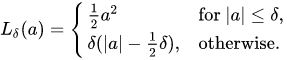

**Note:**

* Huber loss is defined as:

    * error 2/2, if error < delta (ie, if it is a small error)

    * delta * ( |error| - delta/2), otherwise ( |error| means the absolute value error)

  In this exercise, we consider delta=1.

  Thus, the `huber_fn` is defined as:

    * *error 2/2*, if *error < 1* (ie, if it is a small error).

    * *|error| - 0.5*, otherwise

* `tf.abs(x)` returns the positive value(absolute value) of `x`.

* `tf.square(x)` returns the squared value of `x`.

* `tf.where(bool_array, x, y)` returns the elements where condition is True in `bool_array` (multiplexing `x` and `y`).

  In simpler terms, `tf.where` will choose an output shape from the shapes of condition, `x`, and `y` that all three shapes are broadcastable to.

  The condition tensor acts as a mask that chooses whether the corresponding element/row in the output should be taken from x (if the element in the condition is `True`) or from `y` (if it is `False`).

  For example, upon executing the following,

 ` tf.where([True, False, False, True], [1,2,3,4], [100,200,300,400])`

  the output would be :` <tf.Tensor: shape=(4,), dtype=int32, numpy=array([ 1, 200, 300, 4], dtype=int32)>`

In [32]:
  def huber_fn(y_true, y_pred):
        error = y_true - y_pred
        is_small_error = tf.abs(error) < 1
        squared_loss = tf.square(error) / 2
        linear_loss  = tf.abs(error) - 0.5
        return tf.where(is_small_error, squared_loss, linear_loss)

## Building the Network
We shall now build the classification network, with a hidden layer(with 30 neurons and `selu` activation function) and an output layer( with 1 neuron since we have to predict only one value).

We shall also specify the loss function we have defined - the `huber_fn` and the optimizer to use, while compiling.

**Note:**

`kernel_initializer` defines the way to set the initial random weights of Keras layers.

In [33]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", 
       kernel_initializer="lecun_normal", 
       input_shape=X_train.shape[1:]),
    keras.layers.Dense(1),
])

In [34]:
model.compile(loss=huber_fn, optimizer="nadam", metrics=["mae"])

## Training the Model

In [35]:
model.fit(X_train_scaled, y_train, epochs=15,
  validation_data=(X_valid_scaled, y_valid))

Train on 11610 samples, validate on 3870 samples
Epoch 1/15
11610/11610 [==============================] - 2s 134us/sample - loss: 0.5908 - mae: 0.9388 - val_loss: 0.2363 - val_mae: 0.5260
Epoch 2/15
11610/11610 [==============================] - 1s 64us/sample - loss: 0.2072 - mae: 0.4988 - val_loss: 0.1939 - val_mae: 0.4767
Epoch 3/15
11610/11610 [==============================] - 1s 66us/sample - loss: 0.1984 - mae: 0.4861 - val_loss: 0.2134 - val_mae: 0.4945
Epoch 4/15
11610/11610 [==============================] - 1s 66us/sample - loss: 0.1948 - mae: 0.4799 - val_loss: 0.1859 - val_mae: 0.4643
Epoch 5/15
11610/11610 [==============================] - 1s 66us/sample - loss: 0.1912 - mae: 0.4748 - val_loss: 0.1733 - val_mae: 0.4464
Epoch 6/15
11610/11610 [==============================] - 1s 65us/sample - loss: 0.1874 - mae: 0.4688 - val_loss: 0.1832 - val_mae: 0.4597
Epoch 7/15
11610/11610 [==============================] - 1s 63us/sample - loss: 0.1837 - mae: 0.4622 - val_loss: 0.

## Evaluating the Model Performance

In [36]:
model.evaluate(X_test_scaled, y_test)

5160/5160 [==============================] - 0s 32us/sample - loss: 0.1688 - mae: 0.4373


[0.16879631204660547, 0.43733025]

Observe the values of loss and mae. These values are nearly the same as those of the train and validation datasets. Also, the values are low. Hence our model hasn't been overfitted and is giving a decent performance.